In [2]:
from sclibrary.network_reader import NetworkReader
from sclibrary.simplicial_complex import SimplicialComplexNetwork
from sclibrary.plot import SCPlot

from matplotlib import pyplot as plt

### Reading data

In [14]:
data_folder = 'data/paper_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, 
                           src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)

simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# coordinates
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")


# create a simplicial complex network
sc = SimplicialComplexNetwork(simplices=simplices)
# create a plot
scplot = SCPlot(sc, coordinates)

### Spectral analysis of edge space + eigendecomposition

In [5]:
import numpy as np
from sclibrary.eigendecomposition import (get_harmonic_eigenvectors, 
                                          get_curl_eigenvectors, 
                                          get_gradient_eigenvectors,
                                          )

In [6]:
k = 1
L1 = sc.hodge_laplacian_matrix(rank=k)
L1U = sc.upper_laplacian_matrix(rank=k)
L1L = sc.lower_laplacian_matrix(rank=k)
L1

array([[ 3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  3.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3., -1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  3.,  1., -1.,  0.,  0.,  0.],
       [ 0., -1.,  0., -1.,  1.,  2.,  0.,  1.,  0., -1.],
       [ 0.,  0., -1.,  0., -1.,  0.,  2., -1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  3.]], dtype=float32)

In [8]:
u_h, eigenvals_h = get_harmonic_eigenvectors(L1)
u_c, eigenvals_c = get_curl_eigenvectors(L1U)
u_g, eigenvals_g = get_gradient_eigenvectors(L1L)

In [9]:
print("Eigenvalues:", eigenvals_h)
u_h

Eigenvalues: [0.]


array([[ 0.06889728],
       [ 0.13779457],
       [-0.20669185],
       [ 0.06889728],
       [-0.34448642],
       [ 0.55117828],
       [-0.55117828],
       [-0.36745217],
       [-0.18372609],
       [ 0.18372609]])

In [10]:
print("Eigenvalues:", eigenvals_c)
# covert all values to float
u_c = u_c.astype(float)
u_c

Eigenvalues: [2. 4. 3.]


array([[ 5.00000000e-01, -3.53553385e-01,  0.00000000e+00],
       [-1.50107407e-16,  7.07106769e-01,  0.00000000e+00],
       [-5.00000000e-01, -3.53553385e-01,  0.00000000e+00],
       [ 5.00000000e-01, -3.53553385e-01,  0.00000000e+00],
       [ 5.00000000e-01,  3.53553385e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.77350259e-01],
       [ 0.00000000e+00,  0.00000000e+00,  5.77350259e-01],
       [ 0.00000000e+00,  0.00000000e+00, -5.77350259e-01]])

In [11]:
print("Eigenvalues:", eigenvals_g)
u_g

Eigenvalues: [5.48811531 4.45752954 2.32800913 3.59808946 3.31390762 0.81434923]


array([[-0.05878212, -0.36745653,  0.48619685, -0.46687335, -0.09433983,
         0.13607138],
       [ 0.32946974, -0.47395313,  0.0652547 , -0.10648241, -0.31280029,
        -0.1854457 ],
       [-0.1462567 , -0.53557879, -0.32671991, -0.279232  , -0.02961399,
        -0.29740456],
       [ 0.38825187, -0.10649659, -0.42094216,  0.36039096, -0.21846044,
        -0.32151708],
       [-0.47572643, -0.06162565, -0.3919746 , -0.17274958,  0.28318629,
        -0.11195885],
       [-0.49028891,  0.2168476 ,  0.10910526, -0.04279641, -0.21460989,
        -0.59076518],
       [ 0.30512139,  0.41316539,  0.26664403, -0.29986769, -0.08504377,
        -0.51395106],
       [-0.31968388, -0.13469216,  0.23443583,  0.42982084, -0.41275239,
         0.03514474],
       [-0.12263153, -0.28346965,  0.39679703,  0.50137603,  0.27091977,
        -0.23514785],
       [ 0.19705234, -0.14877748,  0.16236119,  0.07155522,  0.68367219,
        -0.27029258]])

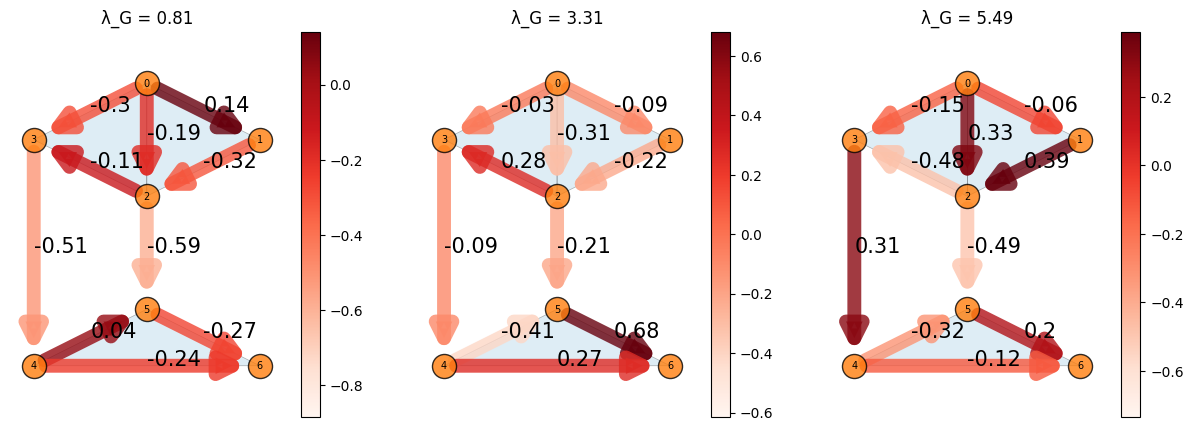

In [30]:
fig = plt.figure(figsize = (15,5))

ax = fig.add_subplot(1, 3, 1)
ax.set_title("λ_G = {}".format(round(eigenvals_g[-1], 2)))
flow = u_g[:, -1]
flow = np.round(flow, 2)
scplot.draw_flow(flow=flow, ax=ax)

ax = fig.add_subplot(1, 3, 2)
ax.set_title("λ_G = {}".format(round(eigenvals_g[4], 2)))
flow = u_g[:, 4]
flow = np.round(flow, 2)
scplot.draw_flow(flow=flow, ax=ax)

ax = fig.add_subplot(1, 3, 3)
ax.set_title("λ_G = {}".format(round(eigenvals_g[0], 2)))
flow = u_g[:, 0]
flow = np.round(flow, 2)
scplot.draw_flow(flow=flow, ax=ax)

### Simplical Shifting

[(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6), (5, 6)]


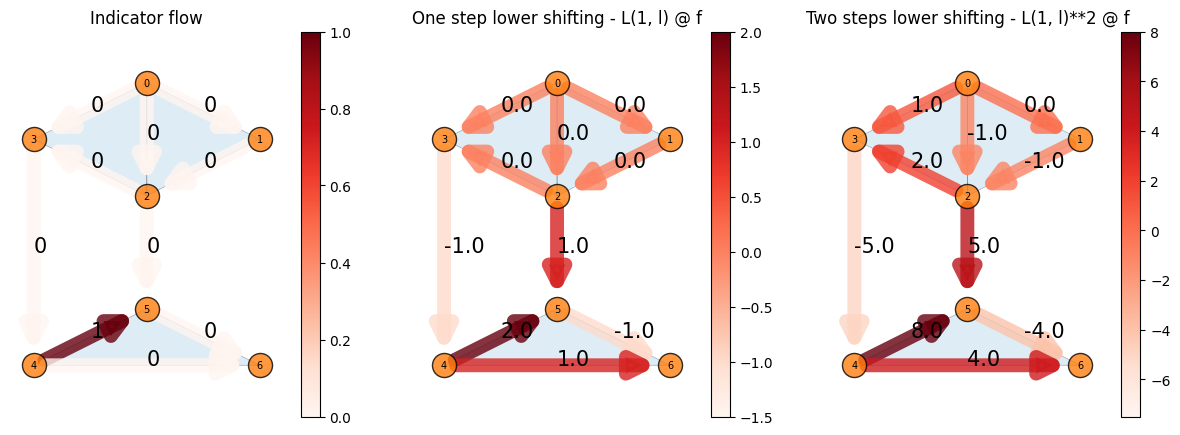

In [31]:
from sclibrary.plot import SCPlot
from matplotlib import pyplot as plt

# get edge labels
edge_labels = {}
for i in range(len(sc.edges)):
    edge_labels[sc.edges[i][0], sc.edges[i][1]] = round(u_c[i][0], 2)

# create plot
scplot = SCPlot(sc=sc, pos=coordinates)

fig = plt.figure(figsize = (15,5))
print(sc.edges)
# indicator flow f
ax = fig.add_subplot(1, 3, 1)
ax.set_title("Indicator flow")
synthetic_flow = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
scplot.draw_flow(flow=synthetic_flow, ax=ax)

# one step lower shifting
ax = fig.add_subplot(1, 3, 2)
ax.set_title("One step lower shifting - L(1, l) @ f")
flow = sc.lower_laplacian_matrix(rank=1) @ synthetic_flow
scplot.draw_flow(flow=flow, ax=ax)

# two steps lower shifting
ax = fig.add_subplot(1, 3, 3)
ax.set_title("Two steps lower shifting - L(1, l)**2 @ f")
lower_flow = sc.lower_laplacian_matrix(rank=1) @ sc.lower_laplacian_matrix(rank=1).T @ synthetic_flow
scplot.draw_flow(flow=lower_flow, ax=ax)

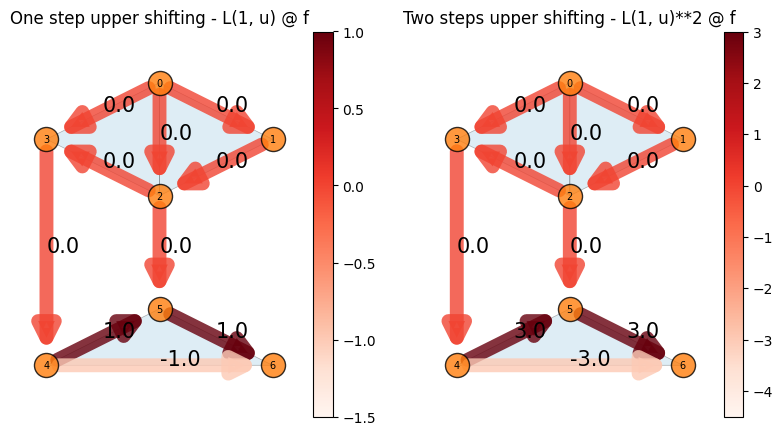

In [32]:
fig = plt.figure(figsize = (15,5))

# one step upper shifting
ax = fig.add_subplot(1, 3, 1)
ax.set_title("One step upper shifting - L(1, u) @ f")
flow = sc.upper_laplacian_matrix(rank=1) @ synthetic_flow
scplot.draw_flow(flow=flow, ax=ax)

# two steps upper shifting
ax = fig.add_subplot(1, 3, 2)
ax.set_title("Two steps upper shifting - L(1, u)**2 @ f")
upper_flow = sc.upper_laplacian_matrix(rank=1) @ sc.upper_laplacian_matrix(rank=1).T @ synthetic_flow
scplot.draw_flow(flow=upper_flow, ax=ax)

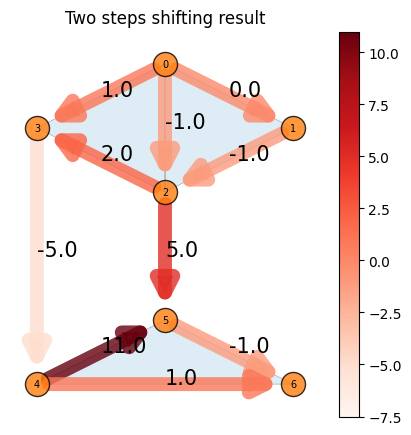

In [33]:
# two step shifting result L1^2 @ f
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Two steps shifting result")
flow = lower_flow + upper_flow
scplot.draw_flow(flow=flow, ax=ax)

### Hodgedecomposition

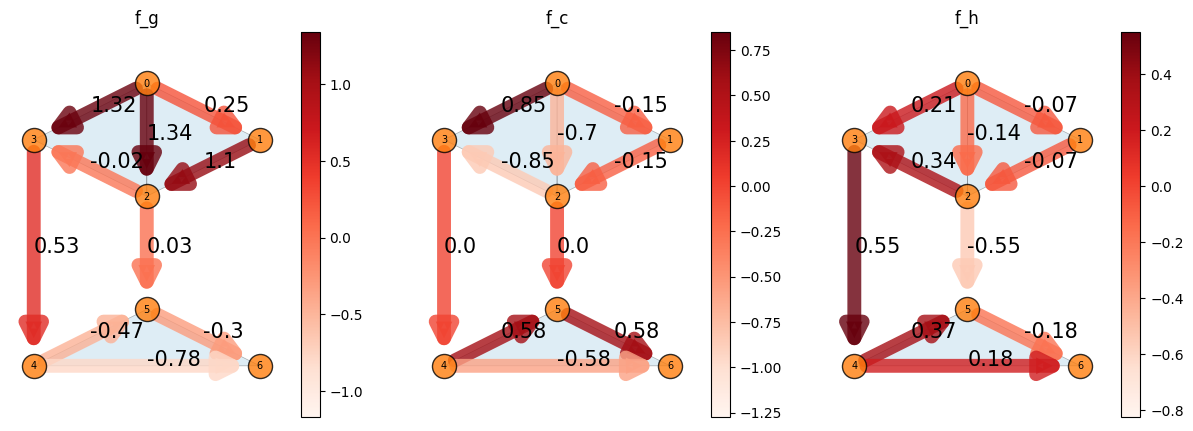

In [34]:
from sclibrary.hodgedecomposition import *

synthetic_flow = [0.03, 0.5, 2.38, 0.88, -0.53, -0.52, 1.08, 0.47, -1.17, 0.09]

fig = plt.figure(figsize = (15,5))
B1 = sc.incidence_matrix(rank=1)

# gradient flow
ax = fig.add_subplot(1, 3, 1)
ax.set_title('f_g')
f_g = get_gradient_component(B1, synthetic_flow)
scplot.draw_flow(flow=f_g, ax=ax)

# curl flow
ax = fig.add_subplot(1, 3, 2)
ax.set_title('f_c')
B2 = sc.incidence_matrix(rank=2)
f_c = get_curl_component(B2, synthetic_flow)
scplot.draw_flow(flow=f_c, ax=ax)

#  harmonic flow    
ax = fig.add_subplot(1, 3, 3)
ax.set_title('f_h')
f_h = get_harmonic_component(B1, B2, synthetic_flow)
scplot.draw_flow(flow=f_h, ax=ax)

### Embeddings of an edge flow - SFT

In [35]:
# each entry of an embed-ding represents the weight the flow has on the corresponding eigenvector 
embedding_h = u_h.T @ synthetic_flow # coefficients of the flow in the harmonic basis
embedding_g = u_g.T @ synthetic_flow # coefficients of the flow in the gradient basis
embedding_c = u_c.T @ synthetic_flow # coefficients of the flow in the curl basis
print("embedding_h", embedding_h)
print("embedding_g", embedding_g)
print("embedding_c", embedding_c)

embedding_h [-1.00084787]
embedding_g [ 1.00412063 -0.99531111 -1.00127706 -1.0028754  -1.00173494 -1.00061497]
embedding_c [-1.         -0.99702054 -0.99881595]


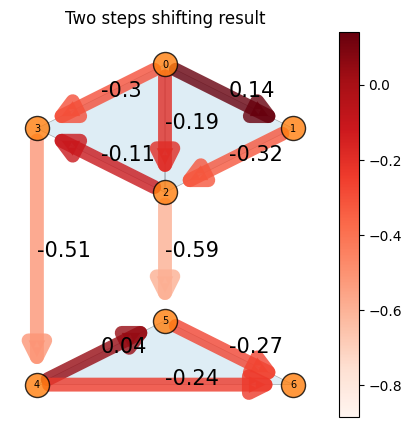

In [36]:
# simplicial fourier transform (SFT)
# stack the coefficients
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Two steps shifting result")
flow = u_g[:, -1]
# round
flow = np.round(flow, 2)
scplot.draw_flow(flow=flow, ax=ax)

### Filters

In [42]:
from sclibrary.eigendecomposition import _get_eigendecomposition


L = 10 # order of the filter (order of the matrix polynomial)

eigenvecs, eigenvals = _get_eigendecomposition(L1)

lam_l = np.diag(eigenvals) # eigenvalues of L1 (all of them)
Phi_G = np.array([lam_l ** (l - 1) for l in range(1, L + 1)]).T

# Calculate alpha
alpha = np.linalg.pinv(Phi_G) @ np.concatenate([np.array([1]), np.zeros(len(lam_l) - 1)])

# Build the filter
H = np.zeros((10, 10))
for l in range(1, L+1):
    H += alpha[l-1] * L1L**(l-1)
    
H

array([[ 1.13655564e+02, -4.71281780e-02, -3.83796312e-02,
         3.12555511e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.10000006e+00, -9.42613344e-02, -3.83796312e-02,
        -3.12561213e-02,  2.54555316e-02,  2.07347615e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.10000006e+00, -4.71281780e-02, -7.67699055e-02,
         0.00000000e+00, -2.54568624e-02,  0.00000000e+00,
         1.68951789e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.11111179e-02, -4.71281780e-02,  0.00000000e+00,
        -6.25354468e-02,  2.54555316e-02,  2.07347615e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000001e-01,  4.71280731e-02, -3.83796312e-02,
         3.12555511e-02, -5.09655806e-02, -2.07378712e-02,
         1.68951789e-02,  0.00000000e+00,  0.00000000e+00,
         0.